In [1]:
import matplotlib.pyplot as plt
import matplotlib._color_data as mcd
import matplotlib.colors as mplc
import scipy.optimize
import jax
from jax.nn import softmax
from jax import grad, jit
import jax.numpy as jnp
from jax.experimental import optimizers
import time
%run Dendrogram.ipynb

In [2]:
fn = 2
dendros = []
for frame_num in range(fn, fn+6):
#     orig = cv2.imread("test_images/tracer/{}.png".format(frame_num),
#                       cv2.IMREAD_GRAYSCALE)
#     orig = orig[50:825, 125:900]
#     orig = cv2.resize(orig, (300, 300))
    orig = cv2.imread("gen/{:02d}.png".format(frame_num), cv2.IMREAD_GRAYSCALE).astype(np.float32)
    im = cv2.GaussianBlur(orig, (3, 3), cv2.BORDER_CONSTANT)
    d = make_dendrogram(-im)
    dendros.append(d)

In [6]:
def cost(params, locs, masses, weights, meta, locality):        

    cost_inertia = 0
    cost_momentum = 0
    cost_vdiv = 0
    cost_locality = 0
    c0, c1, c1_f, c2, c3 = meta
    
    prev_p_j = 0
    for t in range(len(params)):
        link_mat = softmax(params[t][[0], :, :], axis=1)
        mass_mat = link_mat * masses[t][:, None]
        v_mat = params[t][1:, :, :]
        p_mat = mass_mat * v_mat
        p_j = jnp.sum(p_mat, axis=1)
        m_j = jnp.sum(mass_mat, axis=1)
        x_nxt = locs[t+1].T
        
        x_cur = locs[t].T
        com_j = jnp.sum(mass_mat*x_cur[:, :, None], axis=1) / m_j
        overshoot = 1*p_j/m_j - (x_nxt - com_j)
        penalty = weights[t+1] * jnp.linalg.norm(overshoot, axis=0)
        dE_inertia = c0 * jnp.sum(penalty)
        
        p_i = jnp.sum(p_mat, axis=2)
        momentum_lost = p_i - prev_p_j
        penalty = weights[t] * jnp.linalg.norm(momentum_lost, axis=0)
        dE_momentum = c1 * jnp.sum(penalty)
        c1 = c1_f
        prev_p_j = p_j
        
        dE_v_div = 0
        for i in range(v_mat.shape[1]):
            v_div = jnp.trace(jnp.cov(v_mat[:, i, :]))
            dE_v_div += c2 * v_div
            
        dE_locality = 0
        loc_mat = locality[t+1]
        for i in range(link_mat.shape[1]):
            outer_prod = jnp.outer(link_mat[0, i, :], link_mat[0, i, :])
            dE_locality += c3 * jnp.mean(outer_prod * loc_mat)
            
        cost_inertia += dE_inertia
        cost_momentum += dE_momentum
        cost_vdiv += dE_v_div
        cost_locality += dE_locality
#         print(dE_inertia, dE_momentum, dE_v_div, dE_locality)
        
    return cost_inertia + cost_momentum + cost_vdiv + cost_locality

cost = jit(cost, static_argnums=(1,2,3,4,5))
dcost = jit(grad(cost, argnums=0), static_argnums=(1,2,3,4,5))

In [ ]:
def initialize_params(dendrograms, thresh):
    params = []
    for t in range(len(dendrograms)-1):
        cur_sz = dendrograms[t].size
        next_sz = dendrograms[t+1].size
        param_mat = np.zeros((3, cur_sz, next_sz))
        for i, j in np.ndindex(cur_sz, next_sz):
            loc = dendrograms[t].branches[i].loc
            vel = 10 * loc / np.linalg.norm(loc)
            param_mat[1:, i, j] = vel
            sep = dendrograms[t+1].branches[j].loc - dendrograms[t].branches[i].loc
            if np.linalg.norm(sep) < thresh:
                param_mat[0, i, j] = 1
        params.append(param_mat)
    return params

params = initialize_params(dendros, 20)
locs = []
masses = []
wts = []
locality = []
meta = [100, 0, 0.1, 50000, 10000]
static_args = (locs, masses, wts, meta, locality)
for d in dendros:
    locs.append(np.asarray([b.loc for b in d.branches]))
    masses.append(np.asarray([b.exclusive_mass for b in d.branches]))
    wts.append(np.asarray([b.weight for b in d.branches]))
    locality.append(d.locality_mat)
print(cost(params, *static_args))

opt_init, opt_update, get_params = optimizers.adam(step_size=.01)

@jit
def update(i, opt_state):
    params = get_params(opt_state)
    return opt_update(i, dcost(params, *static_args), opt_state)

opt_state = opt_init(params)
    
for step in range(15000):
    opt_state = update(step, opt_state)
    step += 1

params = get_params(opt_state)
print(cost(params, *static_args))
print()

120768.36


In [4]:
cost(params, *static_args)
    
for t in range(len(params)):
    p = params[t]
    link_mat = np.round(softmax(p[0, :, :], axis=1)*100).astype(int)
    print(link_mat)
    print(dendros[t+1].locality_mat)
    v_mat = p[1:, :, :]
    print("FROM")
    count = 0
    for i in range(len(dendros[t].branches)):
        b = dendros[t].branches[i]
        v = np.round(np.mean(v_mat[:, i, :], axis=1))
        dv = np.round(np.trace(np.cov(v_mat[:, i, :]))*100)
        if b.mass_frac <= 0.9:
            link_mat = np.delete(link_mat, b.tree_id-count, axis=0)
            count += 1
        print(np.round(b.mass_frac, 2), v, b.vol, b.traj_id)
    print()
    print("TO")
    count = 0
    for b in dendros[t+1].branches:
        if b.mass_frac <= 0.9:
            link_mat = np.delete(link_mat, b.tree_id-count, axis=1)
            count += 1
        print(np.round(b.mass_frac, 2), b.traj_id)
    print(link_mat)
    print()
    print()
    

NameError: name 'params' is not defined

In [18]:
def assign_trajectories(dendros, params, masses):
    traj_counter = 0
    for b in dendros[0].branches:
        if b.mass_frac > 0.9:
            b.traj_id = traj_counter
            traj_counter += 1
    for t in range(1, len(dendros)):
        mass_mat = softmax(params[t-1][0, :, :], axis=1) * masses[t-1][:, None]
        for tid in range(dendros[t].size):
            this_b = dendros[t].branches[tid]
            if this_b.mass_frac < 0.9 or this_b.traj_id is not None:
                continue
            mass_in_brkdwn = np.sum(mass_mat * dendros[t].subtrees[tid][None, :], axis=1)
            # largest donor
            cur_subroot = dendros[t-1].branches[np.argmax(mass_mat[:, tid])]
            best_bullets = None
            while cur_subroot:
                subtree = cur_subroot.list_descendants()
                mass_contr = 0
                illegal = False
                bullets = np.zeros(dendros[t-1].size)
                for b in subtree:
                    mass_contr += mass_in_brkdwn[b.tree_id]
                    if b.mass_frac > 0.9:
#                         if mass_in_brkdwn[b.tree_id] < 0.8:
#                             illegal = True
#                             break
                        bullets[b.tree_id] = 1
                if illegal:
                    break
                total_mass_in = np.sum(mass_in_brkdwn)
                if mass_contr / total_mass_in > 0.5:
                    best_bullets = bullets
                cur_subroot = cur_subroot.parent
            if best_bullets is not None:
                ind = np.argmax(mass_in_brkdwn * best_bullets)
                largest_donor = dendros[t-1].branches[ind]
                for b in this_b.list_descendants():
                    assert largest_donor.traj_id is not None
                    b.traj_id = largest_donor.traj_id
            else:
                this_b.traj_id = traj_counter
                traj_counter += 1

for d in dendros:
    for b in d.branches:
        b.traj_id = None
assign_trajectories(dendros, params, masses)
                

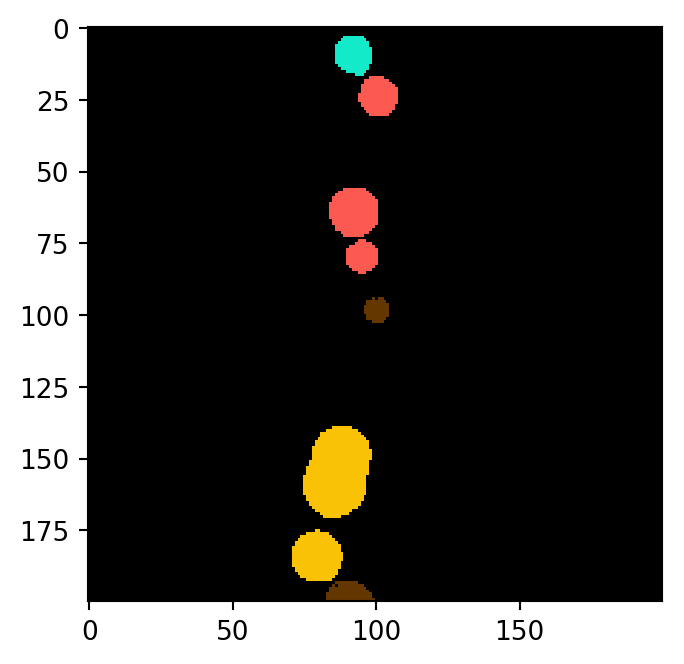

In [46]:
def draw_traj(dendros):
    colors = ["black", "aqua", "coral", "chartreuse", "azure",
              "beige", "goldenrod", "brown", "lavender",
              "fuchsia", "silver", "ivory", "yellow"]
    colors = [mcd.XKCD_COLORS["xkcd:" + c] for c in colors]
    newcmp = mplc.ListedColormap(colors)
    norm = mplc.Normalize(vmin=0, vmax=1.)
    
    for t in range(len(dendros)):
        im = np.zeros((200, 200))
        for b in dendros[t].branches:
            if b.mass_frac > 0.9:
                for loc in b.full_region:
                    im[loc] = (b.traj_id+1)/13.
        plt.imshow(im, cmap=newcmp, norm=norm)
        plt.savefig("results/traj-attempt2/traj-{:02d}.png".format(t))
        
draw_traj(dendros)